# Wind power calculation

Estimate wind power for a single wind farm using ERA5 wind speed

In [113]:
%cd /g/data/w42/dr6273/work/project_demo

/g/data/w42/dr6273/work/project_demo


In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [116]:
FONTSIZE = 10
plt_params = {
    'font.size': FONTSIZE,
    'legend.fontsize' : FONTSIZE - 1,
}

### Wind farm
Stockyard Hill is the largest wind farm in the NEM, with a current capacity of 457 MW: https://opennem.org.au/facility/au/NEM/STOCKYD/?range=3d&interval=30m

Location: 143.25 E, 37.54 S

In [105]:
farm_E = 143.25
farm_N = -37.54
farm_MW = 457

### Wind speed data
Compute ERA5 wind speed for 2020 for the grid cell that contains Stockyard Hill.

We use the meridional and zonal components of 100 m winds.

In [7]:
def preprocess(ds):
    """
    Select grid cell.
    """
    return ds.sel(longitude=farm_E, latitude=farm_N, method="nearest")

In [4]:
era_path = "/g/data/rt52/era5/single-levels/reanalysis/"

In [16]:
u100 = xr.open_mfdataset(
    era_path + "100u/2020/100u_era5_oper_sfc_20200601-20200630.nc",
    preprocess=preprocess
)["u100"]

In [17]:
v100 = xr.open_mfdataset(
    era_path + "100v/2020/100v_era5_oper_sfc_20200601-20200630.nc",
    preprocess=preprocess
)["v100"]

Compute wind speed as $w = \sqrt{u^{2} + v^{2}}$

In [18]:
w100 = np.sqrt(u100**2 + v100**2).compute()

### Capacity factor

In [22]:
def capacity_factor(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3.5 # cut-in speed (m/s)
    W_r = 13 # rated speed
    W_1 = 25 # cut-out speed (m/s)
    
    # Cubic
    c_f = (W ** 3 - W_0 ** 3) / (W_r ** 3 - W_0 ** 3)
    c_f = c_f.where(W >= W_0, 0) # Set values below cut-in to zero
    c_f = c_f.where(W < W_r, 1) # Set values above rated speed to 1
    c_f = c_f.where(W < W_1, 0) # Set values above cut-off to zero
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [23]:
cf = capacity_factor(w100)

### Power [MWh]
Capacity factor [-] multiplied by farm capacity [MW]

In [ ]:
power = cf * farm_MW

### Plot

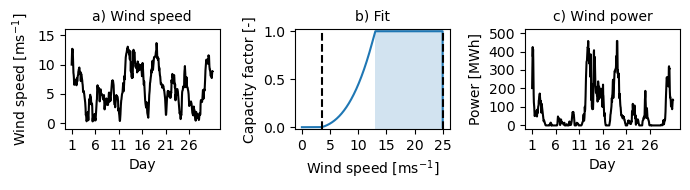

In [132]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 3, figsize=(7, 2.))
    
    # Wind speed
    ax[0].plot(w100.time, w100, c="k")
    ax[0].set_title("a) Wind speed", fontsize=FONTSIZE)
    
    ax[0].set_xticks(w100.time.values[::24*5])
    ax[0].set_xticklabels(range(1,31,5))
    ax[0].set_xlabel("Day")
    
    ax[0].set_ylim(-1, 16)
    ax[0].set_yticks(range(0, 16, 5))
    ax[0].set_ylabel(r"Wind speed [ms$^{-1}$]")
    
    # Capacity factor curve
    x = xr.DataArray(np.linspace(0, 25, 1000))
    p = capacity_factor(x)

    ax[1].plot(x, p,)
    ax[1].axvline(3.5, ls="--", color="k")
    ax[1].axvline(25, ls="--", color="k")
    ax[1].fill_betweenx(y=(-0.05,1.05), x1=13, x2=25, alpha=0.2)

    ax[1].set_xticks(range(0, 26, 5))

    ax[1].set_xlabel(r"Wind speed [ms$^{-1}$]")
    ax[1].set_ylabel("Capacity factor [-]")
    ax[1].set_ylim(-0.02, 1.02)
    
    ax[1].set_title("b) Fit", fontsize=FONTSIZE)
    
    # Wind power
    ax[2].plot(power.time, power, c="k")
    ax[2].set_title("c) Wind power", fontsize=FONTSIZE)
    
    ax[2].set_xticks(power.time.values[::24*5])
    ax[2].set_xticklabels(range(1,31,5))
    ax[2].set_xlabel("Day")
    
    ax[2].set_ylim(-20, 520)
    ax[2].set_yticks(range(0, 501, 100))
    ax[2].set_ylabel(r"Power [MWh]")

    plt.tight_layout()
    
    plt.savefig("./figures/power.pdf", format="pdf", dpi=400, bbox_inches="tight")